# BERTScore From Scratch

In [1]:
import torch
import numpy as np
from transformers import BertTokenizer, BertModel

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def bert_score(reference, candidate, return_similarity_matrix=False):
    
    # Load the BERT tokenizer and model
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = BertModel.from_pretrained("bert-base-uncased")
    
    # Tokenize the input text
    ref_tokens = tokenizer(reference, return_tensors="pt", add_special_tokens=False)
    can_tokens = tokenizer(candidate, return_tensors="pt", add_special_tokens=False)

    # Get the BERT embeddings
    model.eval()
    with torch.no_grad():
        ref_outputs = model(**ref_tokens)
        ref_embeddings = ref_outputs.last_hidden_state[0]

        can_outputs = model(**can_tokens)
        can_embeddings = can_outputs.last_hidden_state[0]
        
    # Compute cosine similarities
    cosine_similarities = np.zeros((can_embeddings.shape[0], ref_embeddings.shape[0]))
    for i, c in enumerate(can_embeddings):
        for j, r in enumerate(ref_embeddings):
            cosine_similarities[i, j] = cosine_similarity(c, r)
    

    # Align cosine similarities
    max_similarities = cosine_similarities.max(axis=1)

    # Average similarity scores
    bertscore = max_similarities.mean()

    if return_similarity_matrix:
        return bertscore, cosine_similarities
    else:
        return bertscore

In [3]:
# Define the input text
reference = "The quick brown fox jumps over the lazy dog."
candidate = "A quick brown fox leaps over a dog."

bert_score(reference, candidate)

/tmp/ipykernel_958934/2515279279.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


np.float64(0.8767200112342834)

In [4]:
bert_score("fast", "quick")

/tmp/ipykernel_958934/2515279279.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


np.float64(0.6320914030075073)

In [5]:
bert_score("fast", "fast")

/tmp/ipykernel_958934/2515279279.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


np.float64(1.0)

In [6]:
reference = "The cat jumped"
candidate = "A cat leaped high"

# Compute BERTScore
bertscore, sim_matrix = bert_score(
    reference, candidate, return_similarity_matrix=True)

print(bertscore)
print(sim_matrix)

0.685903400182724
[[0.63398361 0.52621448 0.51968807]
 [0.59454829 0.71506625 0.68891406]
 [0.55240399 0.68978441 0.69811237]
 [0.55321121 0.69164979 0.69645137]]


/tmp/ipykernel_958934/2515279279.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


In [7]:
import matplotlib.pyplot as plt
import numpy as np


def heatmap(
    matrix,
    hide_spines=False,
    hide_ticks=False,
    figsize=None,
    cmap=None,
    colorbar=True,
    row_names=None,
    column_names=None,
    column_name_rotation=45,
    cell_values=True,
    cell_fmt=".2f",
    cell_font_size=None,
):

    if row_names is not None and len(row_names) != matrix.shape[0]:
        raise AssertionError(
            f"len(row_names) (got {len(row_names)})"
            " should be equal to number of"
            " rows in the input "
            f" array (expect {matrix.shape[0]})."
        )

    if column_names is not None and len(column_names) != matrix.shape[1]:
        raise AssertionError(
            f"len(column_names)"
            " (got {len(column_names)})"
            " should be equal to number of"
            " columns in the"
            f" input array (expect {matrix.shape[1]})."
        )

    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)

    if cmap is None:
        cmap = plt.cm.viridis

    if figsize is None:
        figsize = (len(matrix) * 1.5, len(matrix) * 1.5)

    matshow = ax.matshow(matrix, cmap=cmap)

    if colorbar:
        fig.colorbar(matshow)

    normed_matrix = matrix.astype("float") / matrix.max()

    if cell_values:
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                cell_text = format(matrix[i, j], cell_fmt)

                ax.text(
                    x=j,
                    y=i,
                    size=cell_font_size,
                    s=cell_text,
                    va="center",
                    ha="center",
                    color="black"
                    if normed_matrix[i, j] > np.max(normed_matrix) / 2
                    else "black",
                )

    if row_names is not None:
        tick_marks = np.arange(len(row_names))
        plt.yticks(tick_marks, row_names)

    if column_names is not None:
        tick_marks = np.arange(len(column_names))

        if column_name_rotation:
            plt.xticks(
                tick_marks,
                column_names,
                rotation=column_name_rotation,
                ha="right",
                rotation_mode="anchor",
            )
        else:
            plt.xticks(tick_marks, column_names)

    if hide_spines:
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
    ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("bottom")
    if hide_ticks:
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])

    return fig, ax

/tmp/ipykernel_958934/3624493765.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridisBig = cm.get_cmap('Blues', 512)


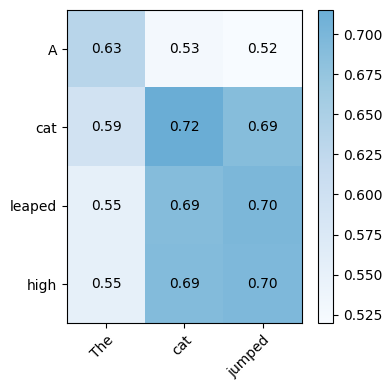

In [8]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

viridisBig = cm.get_cmap('Blues', 512)
newcmp = ListedColormap(viridisBig(np.linspace(0.0, 0.5, 256)))

fig, ax = heatmap(sim_matrix, column_names=reference.split(), row_names=candidate.split(), cmap=newcmp, figsize=(4, 4))

plt.tight_layout()

#plt.savefig('matrix.pdf')
plt.show()

# Using the Official BERTScore package

See https://github.com/Tiiiger/bert_score

In [ ]:
# pip install bert-score

In [9]:
import torch
from bert_score import score

# Define the reference and candidate texts
reference = "The quick brown fox jumps over the lazy dog."
candidate = "A quick brown fox leaps over a lazy dog."

# Compute BERTScore (P, R, F1)
P, R, F1 = score([candidate], [reference], lang='en', model_type='bert-base-uncased',
                 device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Print the BERTScore results
print(f"Precision: {P.item():.4f}")
print(f"Recall: {R.item():.4f}")
print(f"F1 Score: {F1.item():.4f}")

Precision: 0.9040
Recall: 0.9040
F1 Score: 0.9040
